# Comparison of arrival direction and joint models

In order to verify the model is working, we fit simulations made under the assumptions of the model. We also compare the differences between a model for only the UHECR arrival directions and one for both the UHECR arrival directions and energies.

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

# For testing
import sys
sys.path.append('../../../../fancy')

from fancy import Data, Model, Analysis

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Simulation

Set up a simulation using randomly selected sources and the Pierre Auger Observatory as a detector. This simulation will include all the processes described in Section 2 of the paper. 

In [2]:
# Define file containing source catalogue information
source_file = '../../../data/sourcedata.h5'

# Define random seed for reproducible results
random_seed = 1992071502

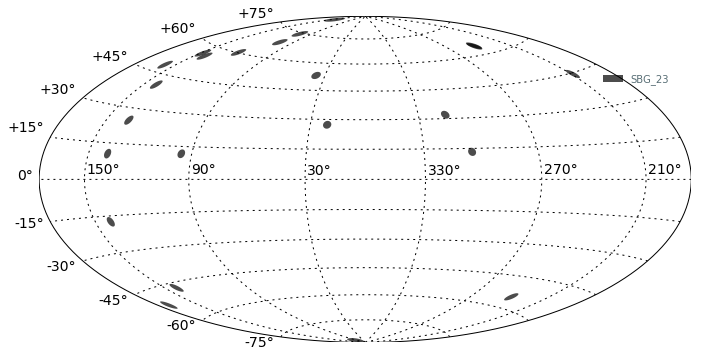

In [3]:
from fancy.detector.auger2014 import detector_properties, alpha_T, M

# Define a source catalogue and detector exposure
# In the paper we use the SBG catalogue
data = Data()
data.add_source(source_file, 'SBG_23')
data.add_detector(detector_properties)

# Plot the sources in Galactic coordinates
data.show();

In [4]:
stan_path = '../../../stan/'

# Define a Stan simulation to run
sim_name = stan_path + 'joint_model_sim.stan' # simulate all processes

# Define simulation using Model object and compile Stan code if necessary
simulation = Model(sim_filename = sim_name, include_paths = stan_path)
simulation.compile()

Using cached StanModel


In [5]:
from fancy.detector.exposure import get_simulation_input

# Define associated fraction
f = 0.5 

# Simulation input
B = 20 # nG
alpha = 3.0
Eth = 52 # EeV
Eth_sim = 20 # EeV

Nsim = 2500 

# L in yr^-1, F in km^-2 yr^-1
L, F0 = get_simulation_input(Nsim, f, data.source.distance, M, alpha_T)

# To scale between definition of flux in simulations and fits
flux_scale = (Eth / Eth_sim)**(1 - alpha)

simulation.input(B = B, L = L, F0 = F0,
            alpha = alpha, Eth = Eth)

In [6]:
# Define output file to store simulation results
sim_output_file = 'output/joint_model_simulation.h5'

# What is happening 
summary = b'Simulation using the joint model and SBG catalogue' # must be a byte str
    
# Define an Analysis object to bring together Data and Model objects
sim_analysis = Analysis(data, simulation, analysis_type = 'joint', 
                    filename = sim_output_file, summary = summary)

In [7]:
# Build pre-computed values for the simulation as you go
# So that you can try out different parameters
sim_analysis.build_tables(sim_only = True)

In [8]:
# Run simulation
sim_analysis.simulate(seed = random_seed, Eth_sim = Eth_sim)

# Save to file 
sim_analysis.save()

running stan simulation...
extracting output...
simulating zenith angles...
done


### Visualise simulation results
Some simple functions are built in to allow quick visualisation of the simulation results. The arrival directions of the UHECRs are shown colour coded by the source component they come from, including the background component. The energy spectrum of the UHECRs is also shown, including the difference between $\tilde{E}$, $E$ and $\hat{E}$. 

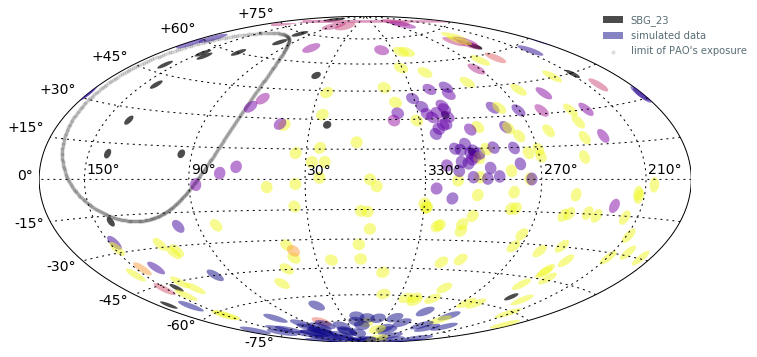

In [9]:
sim_analysis.plot('arrival direction')
# Colours represent source labels

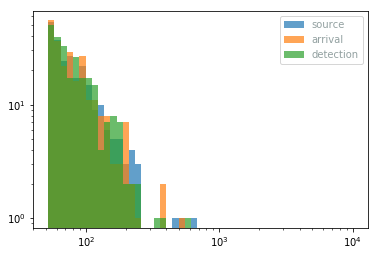

In [10]:
sim_analysis.plot('energy')

## Fit the arrival direction model

In [ ]:
# Define data from simulation
sim_output_file = 'output/joint_model_simulation.h5'
data = Data()
data.from_file(sim_output_file)
data.show();

In [ ]:
# Choose a model to fit
stan_path = '../../../stan/'
model_name = stan_path + 'arrival_direction_only.stan'

# Compile
model = Model(model_filename = model_name, include_paths = stan_path)
model.compile()

# Put this into detector?
model.input(Eth = 52)

In [ ]:
# Define output file to store simulation results
arrival_output_file = 'output/arrival_direction_fit.h5'

# What is happening 
summary = b'Fit of the arrival direction model to the joint simulation' 
# must be a byte str
    
# Define an Analysis object to bring together Data and Model objects
analysis = Analysis(data, model, analysis_type = 'joint', 
                    filename = arrival_output_file, summary = summary)

In [ ]:
# Define location of pre-computed values used in fits 
# (see relevant notebook for how to make these files) 
# Each catalogue has a file of pre-computed values
table_file = '../../../data/integration_tables_50_SBG23.h5'
analysis.use_tables(table_file)

In [ ]:
# Fit the Stan model
random_seed = 1992071502
fit = analysis.fit_model(chains = 4, iterations = 1000, seed = random_seed)

In [ ]:
chain = fit.extract(permuted = True)
fig = fit.plot(['L', 'F0', 'FT', 'f'])
fig.set_size_inches(20, 16)
fig.tight_layout()

In [ ]:
# get truths
# PUT INSIDE PACKAGE
model = {}
with h5py.File(sim_output_file) as f:
    model_handle = f['model']
    for key in model_handle:
        model[key] = model_handle[key].value
flux_scale = (model['Eth'] / 20)**(1 - model['alpha'])

In [ ]:
import corner
key_list = ['F0', 'L', 'f']
labels = [r'$F_0$', r'L', 'f']
truths = [model['F0'], model['L'][0], 0.5]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);

## Fit the joint model

In [ ]:
## Add to this.




## Compare the arrival direction and joint models